In [2]:
# Extra code for Adam Optimiser and Early Stopping

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('heart-disease.csv')

x = data.iloc[:, :-1].values
y = data.iloc[:,-1].values.reshape(-1,1)
y = y.reshape(len(y),1)

# Normalising input features
scaler = StandardScaler()
x = scaler.fit_transform(x)

print(x.shape)
print(y.shape)

# Train / Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)

# Activation Functions
def sigmoid(v):
    return 1/(1+np.exp(-v))

def sigmoid_deriv(v):
    s = sigmoid(v)
    return s * (1 - s)

# Added ReLu function
def ReLu(v):
    return np.maximum(0, v)

def ReLu_deriv(v):
    out = np.ones_like(v)
    out[v <= 0] = 0
    return out

# Leaky ReLu (not used here)
def leaky_ReLu(v):
    return np.where(v > 0, v, 0.01*v)

def leaky_ReLu_deriv(v):
    return np.where(v > 0, 1, 0.01)

def crossEntrop(o,y):
    return (-y*(np.log(o)) - (1-y)* np.log(1-o))

def crossEntrDeriv(o,y):
    return -(y/o - (1-y)/(1-o))

# Hyperparameters
input_nodes = x.shape[1]
hidden_nodes = 16
output_nodes = 1
learning_rate = 0.001  # typical learning rate for Adam
epochs = 1000
mini_batch = 64

# Initialize weights and biases
np.random.seed(42)
w1 = np.random.uniform(-1, 1, (input_nodes, hidden_nodes))
b1 = np.zeros((1, hidden_nodes))
w2 = np.random.uniform(-1, 1, (hidden_nodes, output_nodes))
b2 = np.zeros((1, output_nodes))

# Adam parameters
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

# Initialise moment vectors for each parameter
m_w1 = np.zeros_like(w1)
v_w1 = np.zeros_like(w1)
m_b1 = np.zeros_like(b1)
v_b1 = np.zeros_like(b1)
m_w2 = np.zeros_like(w2)
v_w2 = np.zeros_like(w2)
m_b2 = np.zeros_like(b2)
v_b2 = np.zeros_like(b2)

# Early stopping parameters
patience = 10
patience_count = 0
best_loss = np.inf

train_E = []
train_Acc = []
test_E = []
test_Acc = []

step = 0  # Counts total gradient steps

for epoch in range(epochs):
    train_error_epoch = []
    train_acc_epoch = []
    
    # Mini-batch training
    for i in range(0, len(x_train), mini_batch):
        x_batch = x_train[i:i + mini_batch]
        y_batch = y_train[i:i + mini_batch]

        # Forward pass
        in1 = x_batch @ w1 + b1
        out1 = ReLu(in1)
        in2 = out1 @ w2 + b2
        out2 = sigmoid(in2)

        # Loss / Accuracy
        batch_loss = crossEntrop(out2, y_batch).mean()
        train_error_epoch.append(batch_loss)
        pred_train = np.where(out2 > 0.5, 1, 0)
        train_acc_epoch.append(metrics.accuracy_score(y_batch, pred_train))

        # Backprop
        dEdOut2 = crossEntrDeriv(out2, y_batch)
        dOut2dIn2 = sigmoid_deriv(in2)
        dIn2dW2 = out1
        dEdW2 = (1 / x_batch.shape[0]) * dIn2dW2.T @ (dEdOut2 * dOut2dIn2)
        dEdB2 = (1 / x_batch.shape[0]) * np.ones([1, x_batch.shape[0]]) @ (dEdOut2 * dOut2dIn2)
        
        dIn2dOut1 = w2
        dOut1dIn1 = ReLu_deriv(in1)
        dIn1dW1 = x_batch
        dEdW1 = (1 / x_batch.shape[0]) * dIn1dW1.T @ ((dEdOut2 * dOut2dIn2 @ dIn2dOut1.T) * dOut1dIn1)
        dEdB1 = (1 / x_batch.shape[0]) * np.ones([len(x_batch)]) @ ((dEdOut2 * dOut2dIn2 @ dIn2dOut1.T) * dOut1dIn1)

        # Adam updates
        step += 1
        # Update w2
        m_w2 = beta1 * m_w2 + (1 - beta1) * dEdW2
        v_w2 = beta2 * v_w2 + (1 - beta2) * (dEdW2 ** 2)
        m_w2_hat = m_w2 / (1 - beta1 ** step)
        v_w2_hat = v_w2 / (1 - beta2 ** step)
        w2 -= learning_rate * (m_w2_hat / (np.sqrt(v_w2_hat) + eps))

        # Update b2
        m_b2 = beta1 * m_b2 + (1 - beta1) * dEdB2
        v_b2 = beta2 * v_b2 + (1 - beta2) * (dEdB2 ** 2)
        m_b2_hat = m_b2 / (1 - beta1 ** step)
        v_b2_hat = v_b2 / (1 - beta2 ** step)
        b2 -= learning_rate * (m_b2_hat / (np.sqrt(v_b2_hat) + eps))

        # Update w1
        m_w1 = beta1 * m_w1 + (1 - beta1) * dEdW1
        v_w1 = beta2 * v_w1 + (1 - beta2) * (dEdW1 ** 2)
        m_w1_hat = m_w1 / (1 - beta1 ** step)
        v_w1_hat = v_w1 / (1 - beta2 ** step)
        w1 -= learning_rate * (m_w1_hat / (np.sqrt(v_w1_hat) + eps))

        # Update b1
        m_b1 = beta1 * m_b1 + (1 - beta1) * dEdB1
        v_b1 = beta2 * v_b1 + (1 - beta2) * (dEdB1 ** 2)
        m_b1_hat = m_b1 / (1 - beta1 ** step)
        v_b1_hat = v_b1 / (1 - beta2 ** step)
        b1 -= learning_rate * (m_b1_hat / (np.sqrt(v_b1_hat) + eps))

    # End of epoch, compute average training loss/acc
    train_E.append(np.mean(train_error_epoch))
    train_Acc.append(np.mean(train_acc_epoch))

    # Compute test loss/acc
    in1_test = x_test @ w1 + b1
    out1_test = ReLu(in1_test)
    in2_test = out1_test @ w2 + b2
    out2_test = sigmoid(in2_test)

    test_loss = crossEntrop(out2_test, y_test).mean()
    test_E.append(test_loss)

    pred_test = np.where(out2_test > 0.5, 1, 0)
    test_Acc.append(metrics.accuracy_score(y_test, pred_test))

    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        patience_count = 0
    else:
        patience_count += 1
        if patience_count >= patience:
            print("Early stopping triggered.")
            break

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Train Loss: {train_E[-1]:.4f}, Test Loss: {test_E[-1]:.4f}")

training_final_loss = train_E[-1]
training_final_acc = train_Acc[-1]
testing_final_loss = test_E[-1]
testing_final_acc = test_Acc[-1]
print(f"Final Training Loss: {training_final_loss:.4f}, Final Training Accuracy: {training_final_acc:.4f}")
print(f"Final Testing Loss: {testing_final_loss:.4f}, Final Testing Accuracy: {testing_final_acc:.4f}")


(303, 13)
(303, 1)
Epoch 0 - Train Loss: 1.8098, Test Loss: 2.2926
Epoch 50 - Train Loss: 0.5395, Test Loss: 0.7246
Epoch 100 - Train Loss: 0.3732, Test Loss: 0.4742
Epoch 150 - Train Loss: 0.3237, Test Loss: 0.4265
Epoch 200 - Train Loss: 0.2969, Test Loss: 0.4120
Epoch 250 - Train Loss: 0.2770, Test Loss: 0.4094
Early stopping triggered.
Final Training Loss: 0.2714, Final Training Accuracy: 0.8823
Final Testing Loss: 0.4095, Final Testing Accuracy: 0.8689


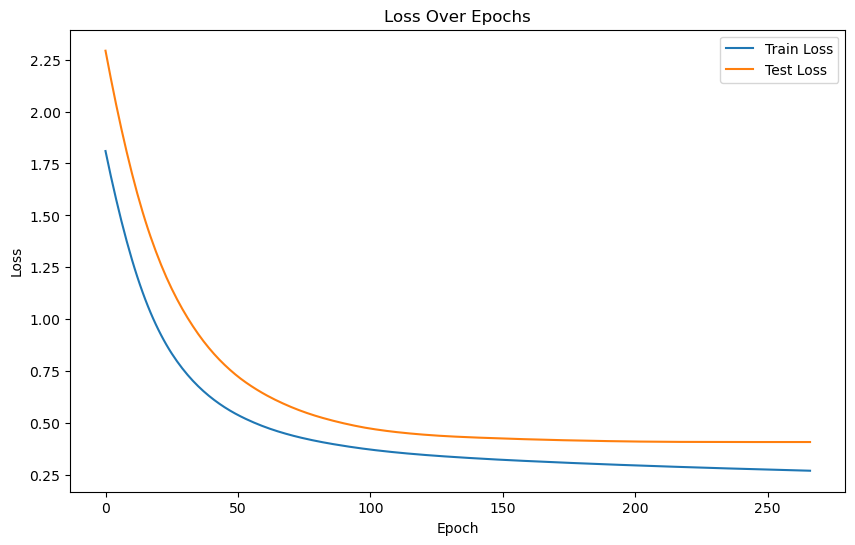

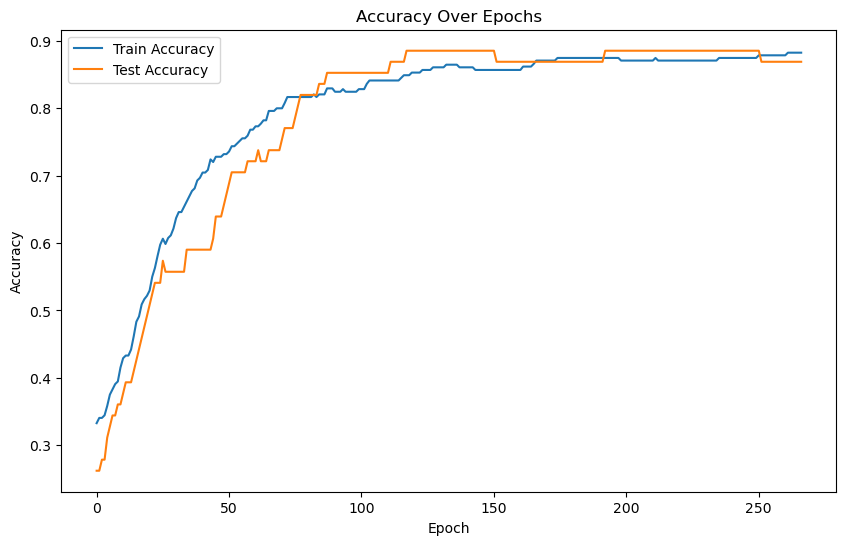

In [6]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,6))
plt.plot(train_E, label='Train Loss')
plt.plot(test_E, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,6))
plt.plot(train_Acc, label='Train Accuracy')
plt.plot(test_Acc, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()